In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import log
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from scipy.stats import norm
import sklearn.feature_selection as fs
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

In [203]:
df = pd.read_csv('final_total_data.csv')
#df.set_index(['Id'])
#df.insert(0,'ID', range(0,len(df)))
df.head(3)

,Id,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,...,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,TotalBsmtSF,WoodDeckSF,YearBuilt_age,NonKitchenBedroomAbvGr,BathRooms
0,1,0,3,1Fam,5,1,6,1,7,Y,...,Gable,Normal,208500.0,WD,0,856.0,0,15,4,4
1,2,0,3,1Fam,5,4,5,1,7,Y,...,Gable,Normal,181500.0,WD,0,1262.0,298,42,2,3
2,3,0,3,1Fam,5,2,6,1,7,Y,...,Gable,Normal,223500.0,WD,0,920.0,0,17,2,4


## Feature Engineering:

In [204]:
# df_1 is the dataframe with the TotalLivingArea and without the lotArea
df['Total_Living_Area'] = df['MasVnrArea'] + df['TotalBsmtSF'] + df['LowQualFinSF'] + df['ScreenPorch'] + df['GarageArea'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['PoolArea'] +df['WoodDeckSF'] + df['GrLivArea'] 
df.drop(['GarageFinish','MasVnrArea','TotalBsmtSF','LowQualFinSF', 'ScreenPorch','GarageArea', 'OpenPorchSF', 'EnclosedPorch','3SsnPorch', 'PoolArea', 'WoodDeckSF', 'GrLivArea','LotConfig', 'ExterQual','BsmtQual','KitchenQual','GarageQual','FireplaceQu','BsmtFinType2','LotShape'], axis = 1, inplace = True)
print(df.columns)

Index(['Id', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'CentralAir', 'Condition1', 'Electrical', 'ExterCond',
       'Exterior1st', 'Fireplaces', 'Foundation', 'GarageCars', 'GarageCond',
       'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr',
       'LandContour', 'LandSlope', 'LotArea', 'MSSubClass', 'MSZoning',
       'MasVnrType', 'MoSold', 'Neighborhood', 'OverallCond', 'OverallQual',
       'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SalePrice',
       'SaleType', 'YearBuilt_age', 'NonKitchenBedroomAbvGr', 'BathRooms',
       'Total_Living_Area'],
      dtype='object')


In [205]:
dic = {'SBrkr':'SBrkr', 'FuseA':'NotSBrkr', 'FuseF':'NotSBrkr','FuseP':'NotSBrkr', 'Mix':'NotSBrkr'}
df['Electrical_clean'] = df['Electrical'].map(dic)

In [206]:
dic = {'Attchd':'Attached', 'Detchd':'Deteched', 'BuiltIn':'Other', 'Basement':'Other', '2Types':'Other', 'CarPort':'Other'}
df['GarageType_clean'] = df['GarageType'].map(dic)

In [207]:
df2 = df.fillna("None")

# Deleting outliers
dfoutlier = df2.drop(df2[(df2['LotArea']>120000) & (df2['Total_Living_Area']>10000)].index)
dfallinput=dfoutlier.drop(columns=['SalePrice'])

## Dummified categorical features:

In [211]:
dfdumm= pd.get_dummies(dfallinput, drop_first=True)
#dfdumm.columns

In [232]:
xtrain=dfdumm[:1460]
xtrain.drop(['Id'], axis = 1, inplace = True)
xtest=dfdumm[1460:]
xtest.drop(['Id'], axis = 1, inplace = True)

#train_ID = xtrain['Id']
#test_ID = xtest['Id']

C:\Users\panka\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [213]:
dftrainoutput=dfoutlier['SalePrice'][:1460]
y= dftrainoutput.astype(int)
y=np.log1p(y)

## Base models score without CV:

In [214]:
lm = LinearRegression()
ridge = Ridge()
lasso = Lasso()
net   = ElasticNet()


lm.fit(xtrain, y)
lm.score(xtrain, y)
print('The Linear RMSE are %s' %(np.sqrt(np.mean((y-lm.predict(xtrain))**2))))

ridge = linear_model.Ridge(alpha=.000000000000001, normalize=True) # create a lasso instance
ridge.fit(xtrain, y) # fit data
print('The Ridge RMSE are %s' %(np.sqrt(np.mean((y-ridge.predict(xtrain))**2))))


lasso = linear_model.Lasso(alpha=.000000001, normalize=True) # create a lasso instance
lasso.fit(xtrain, y) # fit data
print('The Lasso RMSE are %s' %(np.sqrt(np.mean((y-lasso.predict(xtrain))**2))))

net = linear_model.ElasticNet(alpha = .000000000001, l1_ratio = 0.5)
net.fit(xtrain, y) # fit data
#print("The determination of ElasticNet is: %.4f" %elastic.score(xtrain, y))
print('The Elastic RMSE are %s' %(np.sqrt(np.mean((y-net.predict(xtrain))**2))))

The Linear RMSE are 0.11000677860820132
The Ridge RMSE are 0.11000677860820121


C:\Users\panka\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The Lasso RMSE are 0.11000677863674502
The Elastic RMSE are 0.11000677861507947


C:\Users\panka\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [ ]:
lm.fit(xtrain, y)
lm.score(xtrain, y)
print('The Linear RMSE are %s' %(np.sqrt(np.mean((y-lm.predict(xtrain))**2))))

## K-Fold cross validation strategy:

In [215]:
#Validation function
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(xtrain.values)
    rmse= np.sqrt(-cross_val_score(model, xtrain, y, scoring="neg_mean_squared_error", cv=kf))
    return(rmse)

In [216]:
X_train, X_test, y_train, y_test = train_test_split(xtrain, y, test_size = 0.3, random_state=101)

## Base models score with CV:
    Base models performance on the data by evaluating the cross-validation rmsle error


In [222]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

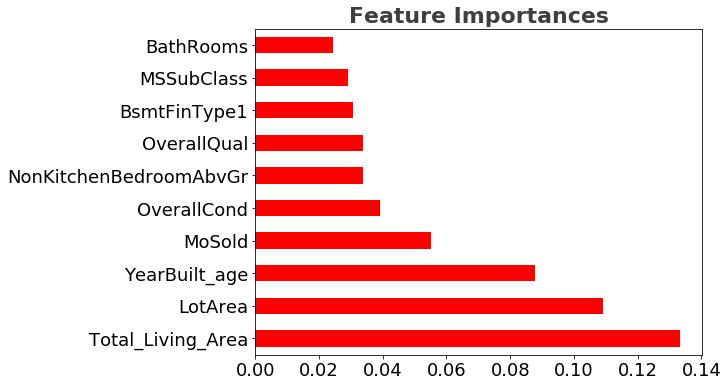

In [223]:
GBoost.fit(X_train, y_train)
importances = pd.Series(data = GBoost.feature_importances_, 
                       index = X_train.columns)
importances_sorted = importances.sort_values(ascending = False)
importances_sorted[:10].plot(kind = 'barh',figsize=(8,6),color = 'red')
plt.title('Feature Importances', fontsize = 22, weight = 'bold', alpha = .75)
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)

In [226]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

C:\Users\panka\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.142347e-19
  overwrite_a=False)
C:\Users\panka\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.688515e-19
  overwrite_a=False)
C:\Users\panka\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.098158e-19
  overwrite_a=False)
C:\Users\panka\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.347920e-19
  overwrite_a=False)
C:\Users\pan

Kernel Ridge score: 0.2456 (0.0622)


Lasso score: 0.1380 (0.0208)

ElasticNet score: 0.1381 (0.0206)

Gradient Boosting score: 0.1241 (0.0109)



## Class for average base models: 

In [227]:
class AveragingModels(BaseEstimator):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

## Average of four base models (ENet, GBoost, KRR and lasso)

In [228]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

C:\Users\panka\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.142347e-19
  overwrite_a=False)
C:\Users\panka\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.688515e-19
  overwrite_a=False)
C:\Users\panka\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.098158e-19
  overwrite_a=False)
C:\Users\panka\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.347920e-19
  overwrite_a=False)


 Averaged base models score: 0.1337 (0.0177)



C:\Users\panka\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.158694e-20
  overwrite_a=False)


## Create rmsle evaluation function:

In [229]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

## Training and Prediction:

In [233]:
averaged_models.fit(X_train, y_train)
train_pred = averaged_models.predict(X_train)
test_pred = np.expm1(averaged_models.predict(xtest))
print(rmsle(y_train, train_pred))

C:\Users\panka\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.978023e-19
  overwrite_a=False)


0.08445424921859848


## Test Dataset Prediction:

In [234]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = test_pred
sub.to_csv('submission.csv',index=False)